In [2]:
import pandas as pd
import numpy as np

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
!wget $data

--2025-08-14 02:44:46--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.1’

laptops.csv.1       100%[===================>] 291.58K  --.-KB/s    in 0.02s   

2025-08-14 02:44:46 (18.2 MB/s) - ‘laptops.csv.1’ saved [298573/298573]



In [4]:
df = pd.read_csv('laptops.csv')

In [7]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [9]:
columns = ['ram', 'storage', 'screen', 'final_price']
df = df[columns]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


<Axes: xlabel='final_price', ylabel='Count'>

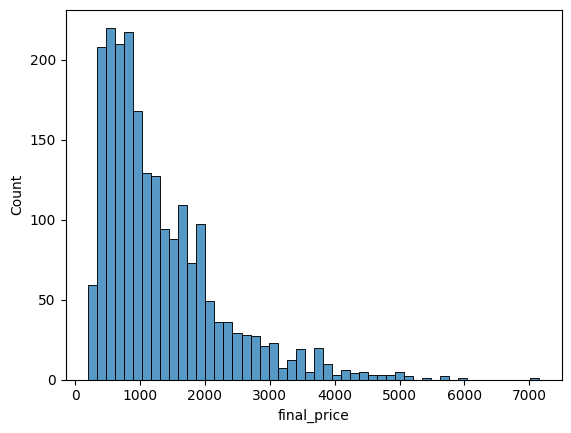

In [10]:
import seaborn as sns
sns.histplot(df['final_price'], bins=50)

In [11]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [13]:
df['ram'].median()

np.float64(16.0)

In [17]:
n = len(df)
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - n_test - n_val

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [23]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

def prepare_X(df, fillna_value):
    df = df.fillna(fillna_value)
    X = df.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)   

In [24]:
# With mean
mean = df_train.ram.mean()

X_train = prepare_X(df_train, fillna_value=mean)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=mean)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(600.3637630345228)

In [25]:
# With 0
X_train = prepare_X(df_train, fillna_value=0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=0)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(597.3635593619622)

In [26]:
# Regularization
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [27]:
for r in [0, 0.01, 1, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred)
    print('%06s %0.2f' % (r, rmse_val))

     0 597.36
  0.01 597.36
     1 597.21
    10 597.06
   100 597.90


In [28]:
# Standard deviation of RMSE

rmses = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w_0 + X_val.dot(w)

    result = rmse(y_val, y_pred)
    print(s, result)
    
    rmses.append(result)


0 565.4520868771027
1 636.7985423056726
2 588.9558697907962
3 597.8148920012521
4 571.962791511102
5 573.2383256618949
6 647.3438328407208
7 550.4398184485952
8 587.333503616991
9 576.1017929433108


In [29]:
#RMSE for Test

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X(df_full_train, fillna_value=0)
y_full_train = np.concatenate([y_train, y_val])
w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

X_test = prepare_X(df_test, fillna_value=0)
y_pred = w_0 + X_test.dot(w)

result = rmse(y_test, y_pred)
print(result)

608.609982204956
